# DarkELF multiphonon notebook

This notebook is meant to illustrate the part of the darkELF package for calculating dark matter-phonon rates in the multiphonon regime.

written by Ethan, updated 05/02/2022

In [1]:
%matplotlib inline

import sys, os
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas
from scipy import interpolate

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

# load the package
from darkelf import darkelf, targets

## Load the materials

DarkELF comes with a number of pre-tabulate data files, which encode important properties of the materials which are difficult and/or slow to compute on the fly. The list of available data files can be accessed with the "targets.files()" command, as illustrated below.

In [2]:
targets.files('GaAs')

Available configuration files: 
	 GaAs.yaml
 
Available data for epsilon: 
	 GaAs_mermin.dat
	 GaAs_epsphonon_data10K.dat
 
Available data for phonon (partial) density of states: 
	 Ga_pDoS.dat
	 As_pDoS.dat
 
Available data for Fn(omega) functions: 
	 As_Fn.dat
	 Ga_Fn.dat
 
Available data for form factors: 
	 Ga_Zion.dat
	 Ga_atomic_Zion.dat
	 As_Zion.dat
	 As_atomic_Zion.dat


For the example above:
    
*    GaAs.yaml contains global properties of the material, such as mass density, atomic numbers etc
*    The espilon data tables parametrize the dielectric function in various regimes and with different computational methods. The dielectric function is not used in the multiphonon calculations. (See darkelf_epsilon.ipynb for details)
*    The phonon partial density of states are needed to compute the multiphonon rate, and were take from the Materials Project. (https://materialsproject.org/) By default, darkELF loads the density of state tables that came with the package, but the user can choose to insert their own extraction by adding the file to the folder of the corresponding material. The user-supplied (p)DOS can then be loaded with the "dos_filename" flag. This flag accepts a single filename as well as a list of filenames. In the former case, it interprets the file as the full DOS of the material. In the latter case, each file will be interpretted as a pDOS.

*    To speed up the computations, the multiphonon rate is computed with pretabulated auxiliary functions "Fn". The default "Fn" functions are calculated for the default density of states provided with darkELF. If using your own density of states, you must first run the "create_Fn_omega()" function on the desired density of states to recompute these pretabulated functions. (See below.) Beware that this step is somewhat time consuming. If the desired pDOS is specified with the "dos_filename" flag, darkELF will automatically load the corresponding Fn table.

*    For a dark photon mediator, the DM couples to the momentum dependent effective charge of the nuclei. By default, DarkELF loads this from a look-up table whenever needed, specified by the Zion.dat files. In the example above, "Ga_Zion.dat" refers to the effective charge of ionized Ga, meaning Z=+3 in the zero momentum limit. "Ga_atomic_Zion.dat" refers to the effective charge of atomic Ga, meaning Z=0 in the zero momentum limit. By default, the atomic effective charges are used. 
   

Let's load a few materials.

In [3]:
gaas = darkelf(target='GaAs')
print("------")
si = darkelf(target='Si')
print("------")

 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation not loaded. Using Z - number of valence electrons.
Loaded Ga_atomic_Zion.dat and As_atomic_Zion.dat for effective charges
Loaded Ga_pDoS.dat and As_pDoS.dat for partial densities of states
Loaded Fn(omega) functions corresponding to densi

# Cross section plots

Now using the sigma_nucleon function to calculate the required DM-nucleon cross-section for a rate of 3 events/kg/yr

In [4]:
?gaas.sigma_multiphonons

Signature: gaas.sigma_multiphonons(threshold, dark_photon=False)
Docstring:
returns DM-proton cross-section [cm^2] corresponding to 3 events/kg/yr
Inputs
------
threshold: float
  experimental threshold, in eV
dark_photon: Bool
  If set to True, a dark photon mediator is assumed, by setting f_d(q) = Z_d(q), with Z_d(q) the momentum dependent effective charges. If set to False, darkELF sets f_d=A_d, which corresponds to a scalar mediator with coupling to nuclei.
File:      ~/Documents/work/projects/DM_stuff/darkELF_public/darkelf/multiphonon.py
Type:      method


Points 0 to 4 took 20.630828142166138 seconds to calculate
Points 5 to 9 took 37.963016986846924 seconds to calculate
Points 10 to 14 took 56.35818004608154 seconds to calculate
Points 15 to 19 took 78.48001503944397 seconds to calculate
Points 20 to 24 took 81.53652811050415 seconds to calculate
Points 25 to 29 took 109.66098260879517 seconds to calculate
Points 30 to 34 took 110.83655714988708 seconds to calculate
Points 35 to 39 took 116.02507901191711 seconds to calculate


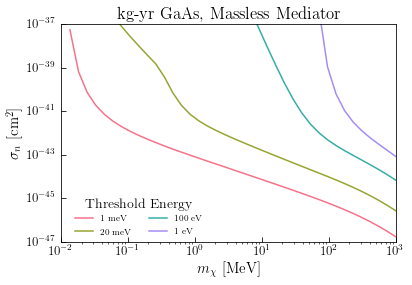

In [5]:
import seaborn as sns

points = 40

mdm = np.logspace(4, 9, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)
reaches4 = np.zeros(points)

import time

for i, mass in enumerate(mdm):
    gaas.update_params(mX = mass, mMed = 0) # update the DM mass
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = gaas.sigma_multiphonons(threshold=1e-3)
    reaches2[i] = gaas.sigma_multiphonons(threshold=20e-3)
    reaches3[i] = gaas.sigma_multiphonons(threshold=1e-1)
    reaches4[i] = gaas.sigma_multiphonons(threshold=1)

    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$20$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$100$ eV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r'kg-yr GaAs, Massless Mediator')

ax.set_xlim([1e-2,1e3])
ax.set_ylim([1e-47,1e-37])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-47,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

plt.savefig(plotdir+"gaas_massless_multiphonon.pdf",bbox_inches='tight')


If starting with a new density of states, one must run the 'create_Fn_omega()' function. (see below.) This defaults to creating the Fn functions corresponding to the density of states (or list of partial density of states) loaded in in the instantiation of the class. This can take an hour or more. 

# Differential Rate $\frac{dR}{d\omega}$

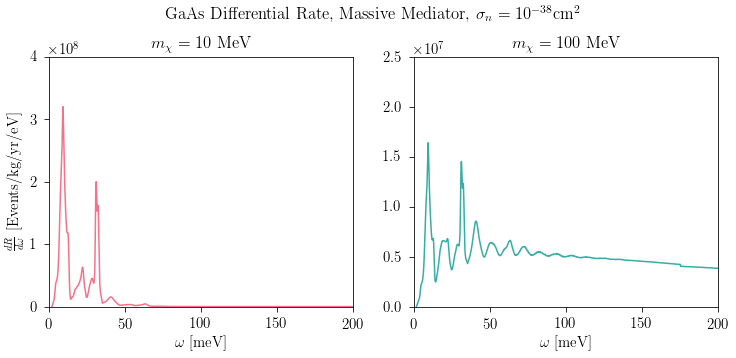

In [6]:
import seaborn as sns

omegarange = np.linspace(1e-4, 200e-3, 2000)

gaas.update_params(mX = 1e7, mMed = 1e9) # update the DM mass

dr_domega1 = [gaas._dR_domega_multiphonons_no_single(omega) for omega in omegarange]

gaas.update_params(mX = 1e8, mMed = 1e9) # update the DM mass

dr_domega2 = [gaas._dR_domega_multiphonons_no_single(omega) for omega in omegarange]

colors = sns.color_palette("husl", 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

ax1.plot(omegarange*1e3, dr_domega1, color=colors[0])
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1])


ax1.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax2.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax1.set_ylabel(r'$\frac{dR}{d\omega} \ [\mathrm{Events}/\mathrm{kg}/\mathrm{yr}/\mathrm{eV}]$',fontsize=15)


ax1.set_title(r'$m_\chi = 10$ MeV')
ax2.set_title(r'$m_\chi = 100$ MeV')

ax1.set_xlim([0,200])
ax2.set_xlim([0,200])

ax1.set_ylim([0,4e8])
ax2.set_ylim([0,2.5e7])


xtick_major = [50*n for n in range(5)]
ytick_major = [1e8*n for n in range(5)]
ax1.set_yticks(ytick_major)

ax1.set_xticks(xtick_major)
ax2.set_xticks(xtick_major)

ytick_major = [0.5e7*n for n in range(6)]
ax2.set_yticks(ytick_major)

plt.suptitle(r'GaAs Differential Rate, Massive Mediator, $\sigma_n = 10^{-38} \mathrm{cm}^2$', y=1.03)

plt.savefig(plotdir+"gaas_massive_rates.pdf",bbox_inches='tight')

# Custom Momentum-dependent coupling (Dark Photon)

Here we calculate the cross-section for a rate of 3 events/kg/yr for a dark photon, using custom atomic couplings. In order to do this, the form factor must be loaded in at the instantiation of the class via 'fd_filename' (multiple filenames if multiple atoms) and the flag 'dark_photon' must be set to 'True' in function calls. Note that the default coupling without a custom coupling is the mass number.

Our effective charge here is valid for processes dominated by large momenta (massive mediator or $\geq2$-phonon calculations.

 .... Loading files for Si
Loaded Si_gpaw_withLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.
phonon ELF taken or calculated from M. Ikezawa and M. Ishigame, Far-Infrared AbsorptionDue to the Two-Phonon Difference Process in Si, Journal of the Physical Society of Japan 50(1981) 3734.
Loaded Si_epsphonon_data6K.dat for epsilon in phonon regime
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded Si_atomic_Zion.dat for dark photon couplings
Loaded Si_DoS.dat for density of states
Loaded Fn(omeg

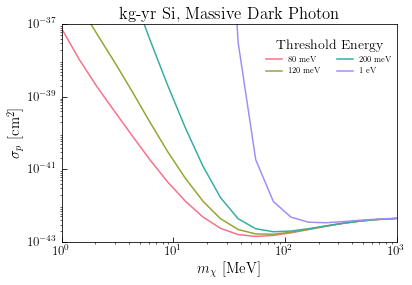

In [7]:
import seaborn as sns

# Loads dark photon form factor 
si = darkelf(target='Si',dos_filename="Si_DoS.dat",
             fd_filename='Si_atomic_Zion.dat')

points = 20

mdm = np.logspace(6, 9, points)

(reaches1, reaches2, reaches3, reaches4) = (np.zeros(points),np.zeros(points),np.zeros(points),np.zeros(points))

import time

for i, mass in enumerate(mdm):
    si.update_params(mX = mass, mMed = 1e10) # update the DM mass
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = si.sigma_multiphonons(80e-3, dark_photon=True)
    reaches2[i] = si.sigma_multiphonons(120e-3, dark_photon=True)
    reaches3[i] = si.sigma_multiphonons(200e-3, dark_photon=True)
    reaches4[i] = si.sigma_multiphonons(1000e-3, dark_photon=True)


    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()

ax.plot(mdm/1e6, reaches1, label='$80$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$120$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$200$ meV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e0,1e3])
ax.set_ylim([1e-43,1e-37])

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_p \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

xtick_major = [pow(10.,n) for n in range(0,4,1)]
ytick_major = [pow(10.,n) for n in range(-43,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.set_title(r'kg-yr Si, Massive Dark Photon')

ax.legend(loc=(0.60,0.75),fontsize=8,frameon=False,ncol=2,title="Threshold Energy",)

plt.savefig(plotdir+"si_massive_dark_photon.pdf",bbox_inches='tight')


## Using a user-supplied DOS table

The user can update the pretabulated Fn function with their own density of states, using the "create_Fn_omega" function. To demonstrate how this works, we included to the "Ga_pDoS_test.dat" and "As_pDoS_test.dat" files, which are identical to "Ga_pDoS.dat" and "As_pDoS.dat" and just serve to illustrate how to include user supplied pDOS files. Concretely, we first make a new darkELF object, specifying these new pDOS files:



In [8]:
# just deleting any potential left-over Fn files from previous runs
if os.path.isfile(work_dir+"/../data/GaAs/Ga_Fn_test.dat"):
    os.remove(work_dir+"/../data/GaAs/Ga_Fn_test.dat")        
if os.path.isfile(work_dir+"/../data/GaAs/As_Fn_test.dat"):
    os.remove(work_dir+"/../data/GaAs/As_Fn_test.dat")
    
gaas_test = darkelf(target='GaAs',dos_filename=["Ga_pDoS_test.dat","As_pDoS_test.dat"])

 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation not loaded. Using Z - number of valence electrons.
Loaded Ga_atomic_Zion.dat and As_atomic_Zion.dat for effective charges
Loaded Ga_pDoS_test.dat and As_pDoS_test.dat for partial densities of states
Warning! Fn(omega) functions not loaded

because GaAs is diatomic crystal, we specified both files a list as an argument to "dos_filename". Note that the definition of the object produces a warning if it doesn't find the Fn files, indicating that the user should run "create_Fn_omega", as below. The option "npoints" indicat the number of points in the grid that is generated; we recommend at least npoints=750 for good accuracy. Since this is step rather slow, we will here run with npoints=20 for illustrative purposes. (This grid should NOT be used for physics calculations.)

The code will spit out a status update if it completed a particular final state.

In [9]:
gaas_test.create_Fn_omega(npoints=20)

/Users/knapen/Documents/work/projects/DM_stuff/darkELF_public/darkelf/../data/GaAs/Ga_Fn_test.dat
6.089571237564087 seconds for 2 phonons
12.606563091278076 seconds for 3 phonons
17.43221092224121 seconds for 4 phonons
23.00077199935913 seconds for 5 phonons
24.507512092590332 seconds for 6 phonons
24.03567099571228 seconds for 7 phonons
26.086449146270752 seconds for 8 phonons
20.12293791770935 seconds for 9 phonons
19.311187982559204 seconds for 10 phonons
result saved in /Users/knapen/Documents/work/projects/DM_stuff/darkELF_public/darkelf/../data/GaAs/Ga_Fn_test.dat
/Users/knapen/Documents/work/projects/DM_stuff/darkELF_public/darkelf/../data/GaAs/As_Fn_test.dat
6.521359920501709 seconds for 2 phonons
10.285343885421753 seconds for 3 phonons
16.31454110145569 seconds for 4 phonons
26.151064157485962 seconds for 5 phonons
31.615352630615234 seconds for 6 phonons
29.583627939224243 seconds for 7 phonons
24.783081769943237 seconds for 8 phonons
24.056915044784546 seconds for 9 phonons

At the end of this process, a the output will be stored in as a look-up table in a new "Fn" file, for future usage. The name of the Fn files is based on the name of the DoS files as follows


Ga_pDoS_test.dat --> Ga_Fn_test.dat

As_pDos_test.dat -> As_Fn_test.dat

 
etc. 

It is important that the filenames of all user-supplied DOS or partial DOS files include the string "DoS" or "pDoS" respectively. When running the code, it suffices to specify the desired DOS file(s) with the "dos_filename" flag in the constructor. DarkELF will then automatically load in the corresponding Fn-tables, or calculate them if needed.  If we now reload the darkELF object, the warning should have disappeared.

In [10]:
gaas_test = darkelf(target='GaAs',dos_filename=["Ga_pDoS_test.dat","As_pDoS_test.dat"])

 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation not loaded. Using Z - number of valence electrons.
Loaded Ga_atomic_Zion.dat and As_atomic_Zion.dat for effective charges
Loaded Ga_pDoS_test.dat and As_pDoS_test.dat for partial densities of states
Loaded Fn(omega) functions correspondin

The new darkelf object can now be used for calculations

In [11]:
print(gaas_test.sigma_multiphonons(0.1))
print(gaas.sigma_multiphonons(0.1))

1.0973728262098506e-28
1.9867474456553369e-44


Numerical difference is here due to the poor resolution of the Fn functions we calculated for the gaas_test object.